In [4]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [5]:
# --------- Helper functions ---------
def order_points(pts):
    """
    Order 4 points as top-left, top-right, bottom-right, bottom-left.
    pts: array-like shape (4,2)
    Returns float32 array shape (4,2)
    """
    pts = np.array(pts, dtype="float32")
    s = pts.sum(axis=1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype="float32")


def blend_warped_into_gallery(gallery, warped, polygon_int, feather_radius=15):
    """
    Blend the warped image into gallery using a soft (feathered) mask.
    - gallery, warped: full-image arrays (same shape)
    - polygon_int: Nx2 int32 polygon (in original gallery coords)
    - feather_radius: approximate gaussian blur radius for feathering edges
    Returns blended result (uint8).
    """
    h, w = gallery.shape[:2]

    # single-channel mask
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillConvexPoly(mask, polygon_int, 255)

    # Feather (blur) the mask to smooth edges
    # Kernel size should be odd and scale with feather_radius, clip to image size
    k = max(1, int(feather_radius))
    if k % 2 == 0:
        k += 1
    mask_blur = cv2.GaussianBlur(mask, (k, k), 0)

    # Convert to float alpha in [0,1]
    alpha = (mask_blur.astype(np.float32) / 255.0)[:, :, None]

    # Ensure warped and gallery are float32 for blending
    gallery_f = gallery.astype(np.float32)
    warped_f = warped.astype(np.float32)

    blended = gallery_f * (1.0 - alpha) + warped_f * alpha
    blended = np.clip(blended, 0, 255).astype(np.uint8)
    return blended



In [18]:
def replace_with_fixed_points(gallery_img, replacement_path, gallery_points):
    """
    Replace a quadrilateral region in gallery image with replacement image.

    gallery_img: NumPy array of the current gallery (BGR)
    replacement_path: path to replacement (new) image
    gallery_points: list/array of 4 points (x,y) in gallery coords
    Returns: updated gallery image (NumPy array)
    """
    # Load replacement image
    replacement_img = cv2.imread(replacement_path)
    if replacement_img is None:
        raise FileNotFoundError(f"Replacement image not found: {replacement_path}")
    
    # Ensure points are float32
    dst_pts = order_points(np.array(gallery_points, dtype=np.float32))
    
    # Replacement dimensions (we'll map the entire replacement image into that quadrilateral)
    (h, w) = replacement_img.shape[:2]
    src_pts = np.array([
        [0, 0],
        [w-1, 0],
        [w-1, h-1],
        [0, h-1]], dtype=np.float32)
    
    # Compute perspective transform (warp replacement into gallery shape)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(replacement_img, M, (gallery_img.shape[1], gallery_img.shape[0]))
    
    # Create mask of replacement region
    mask = np.zeros(gallery_img.shape[:2], dtype="uint8")
    cv2.fillConvexPoly(mask, dst_pts.astype(int), 255)
    
    # Black-out the area in gallery and add warped replacement
    masked_gallery = cv2.bitwise_and(gallery_img, gallery_img, mask=cv2.bitwise_not(mask))
    updated_gallery = cv2.add(masked_gallery, warped)

    if isinstance(updated_gallery, str):  # if path, load
        img = cv2.imread(updated_gallery)
        if img is None:
            raise FileNotFoundError(f"Image not found: {updated_gallery}")
    else:
        img = updated_gallery
    
    # Convert BGR → RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Updated gallery")
    plt.show()
    
    return updated_gallery


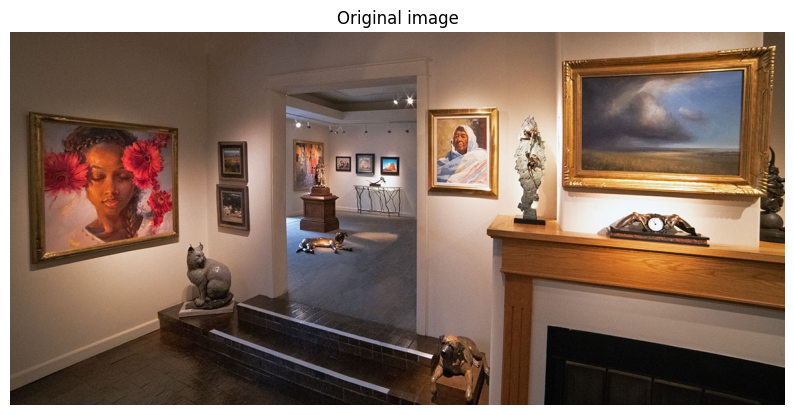

In [19]:
if __name__ == "__main__":

    image_path = "art-gallery.jpg"
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Convert BGR (OpenCV default) to RGB (matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Show inline
    plt.figure(figsize=(10,8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Original image")
    plt.show()

    


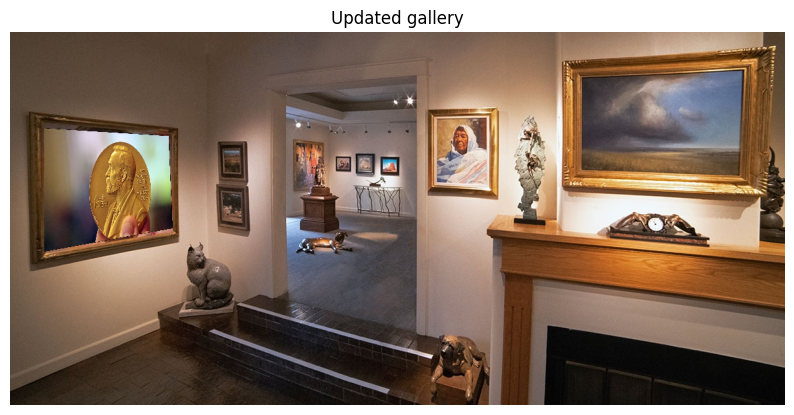

In [29]:
gallery = cv2.imread("art-gallery.jpg")

# First replacement
points1 = [[53, 150], [245, 162], [251, 304], [53, 340]]
updated_gallery = replace_with_fixed_points(gallery, "nobel-prize-medal.jpg", points1)

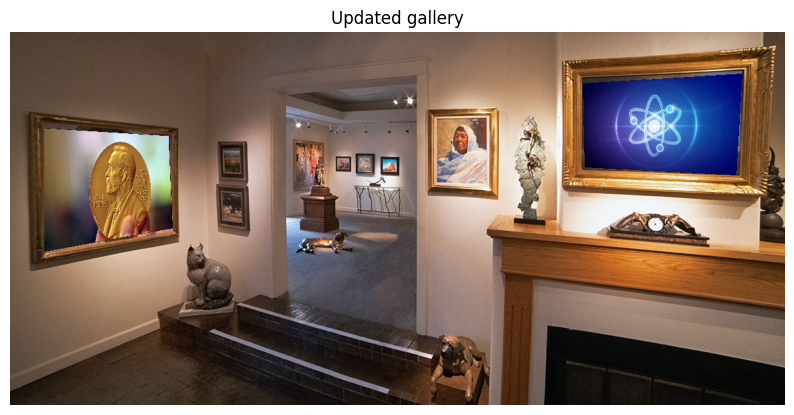

In [31]:
points2 = [[887, 81], [1133, 66], [1124, 222], [890, 210]]
updated_gallery = replace_with_fixed_points(updated_gallery, "atom.jpg", points2)

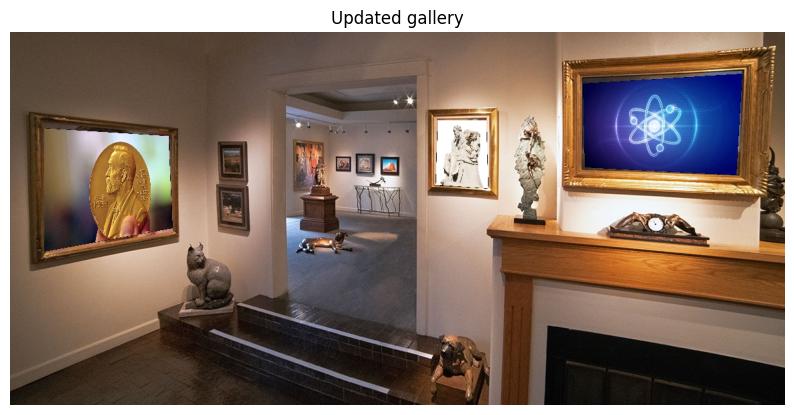

In [32]:
points3 = [(662, 138), (737, 138), (740, 243), (659, 237)]
updated_gallery = replace_with_fixed_points(updated_gallery, "greek-thinker.jpg", points3)